Training on: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Starting Training...
Epoch [1/10], Loss: 0.0351
Epoch [2/10], Loss: 0.0234
Epoch [3/10], Loss: 0.0224
Epoch [4/10], Loss: 0.0220
Epoch [5/10], Loss: 0.0218
Epoch [6/10], Loss: 0.0214
Epoch [7/10], Loss: 0.0212
Epoch [8/10], Loss: 0.0212
Epoch [9/10], Loss: 0.0210
Epoch [10/10], Loss: 0.0209
Training Finished.


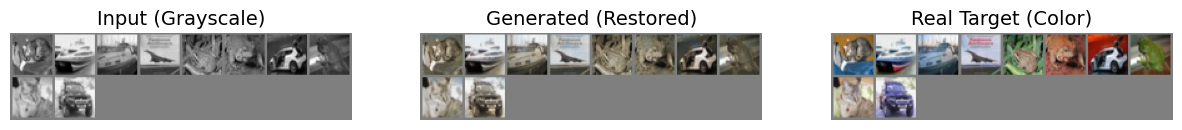

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Config
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

# 1. Load & Normalize Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Downloading CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

# 2. Define Encoder-Decoder CNN
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        # Encoder: Grayscale (1ch) -> Latent
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder: Latent -> RGB (3ch)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh() # Output [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EncoderDecoder().to(DEVICE)

# 3. Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. Training Loop
print("Starting Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data

        # Create Pair: Input (Grayscale) -> Target (Color)
        grayscale = torch.mean(images, dim=1, keepdim=True).to(DEVICE)
        targets = images.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(grayscale)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')

print("Training Finished.")

# 5. Visualize Results
def imshow(img, title):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title, fontsize=14)
    plt.axis('off')

# Get batch
dataiter = iter(test_loader)
images, _ = next(dataiter)

# Prepare inputs
grayscale_input = torch.mean(images, dim=1, keepdim=True).to(DEVICE)

# Generate
with torch.no_grad():
    generated_color = model(grayscale_input).cpu()

plt.figure(figsize=(15, 6))

# Show Grayscale Inputs
plt.subplot(1, 3, 1)
imshow(torchvision.utils.make_grid(grayscale_input.cpu()), "Input (Grayscale)")

# Show Generated Output
plt.subplot(1, 3, 2)
imshow(torchvision.utils.make_grid(generated_color), "Generated (Restored)")

# Show Real Targets
plt.subplot(1, 3, 3)
imshow(torchvision.utils.make_grid(images), "Real Target (Color)")

plt.show()

--- Multi-Prompt Generator (Running on cuda) ---


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--timbrooks--instruct-pix2pix/snapshots/31519b5cb02a7fd89b906d88731cd4d6a7bbf88d/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loaded image. Processing 7 prompts...

🎨 Generating 1/7: 'Change the background to a snowy forest'...


  0%|          | 0/40 [00:00<?, ?it/s]

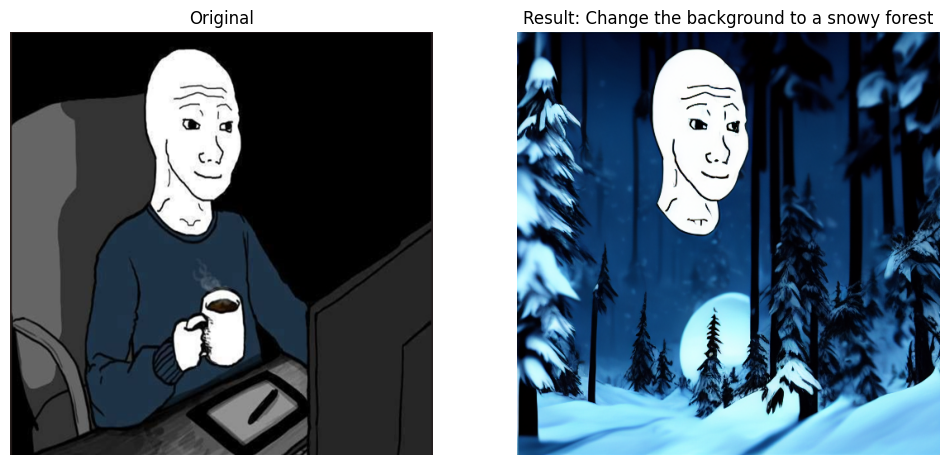

----------------------------------------
🎨 Generating 2/7: 'Make the lighting neon cyberpunk'...


  0%|          | 0/40 [00:00<?, ?it/s]

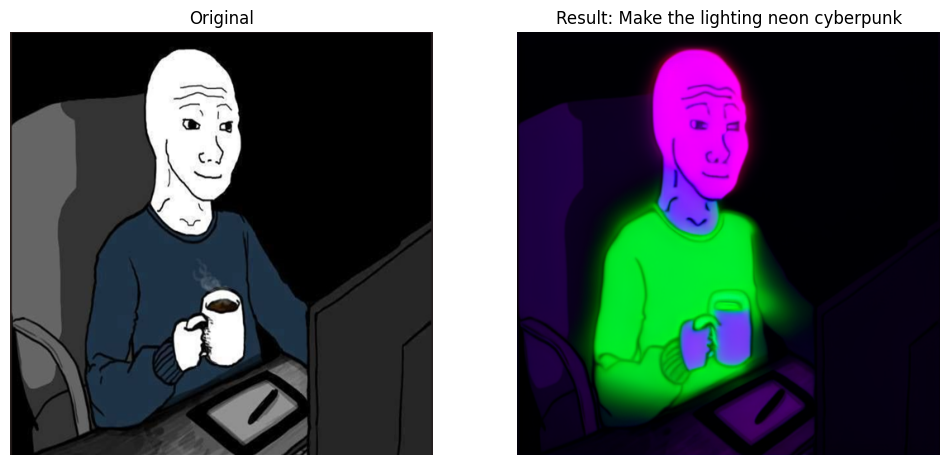

----------------------------------------
🎨 Generating 3/7: 'make me sit in open mountains'...


  0%|          | 0/40 [00:00<?, ?it/s]

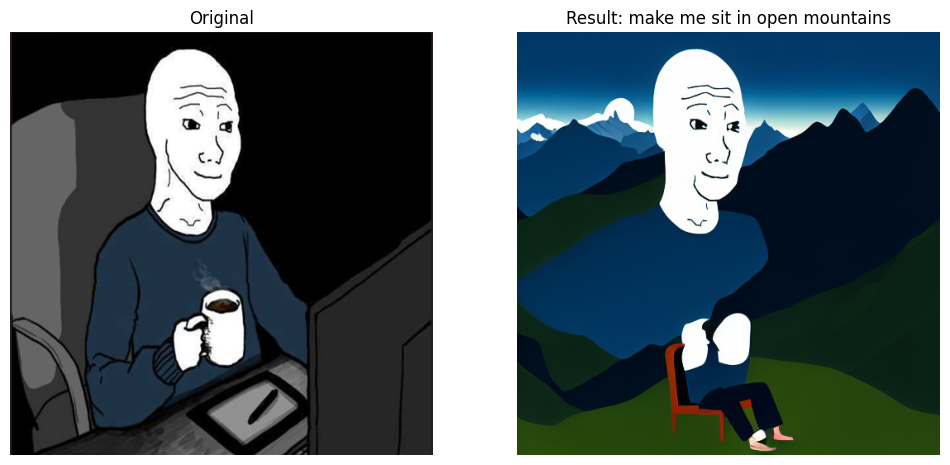

----------------------------------------
🎨 Generating 4/7: 'make me sit in a modern classroom'...


  0%|          | 0/40 [00:00<?, ?it/s]

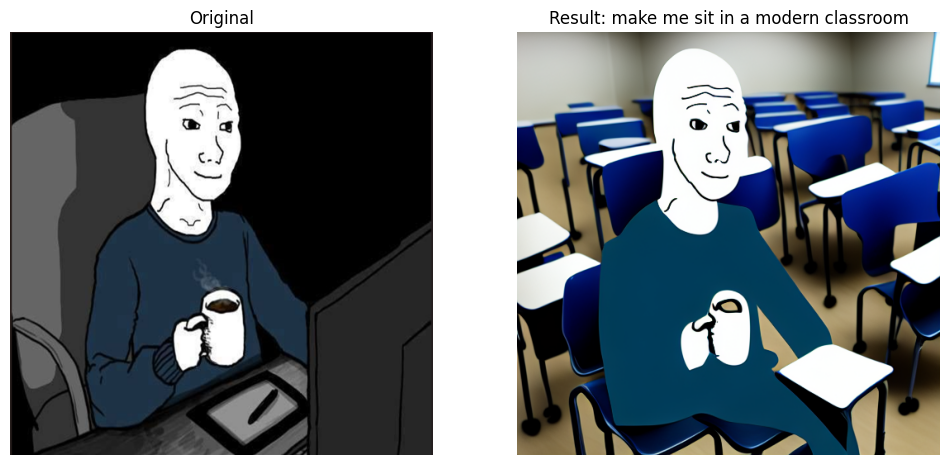

----------------------------------------
🎨 Generating 5/7: 'turn the background into a cyberpunk city'...


  0%|          | 0/40 [00:00<?, ?it/s]

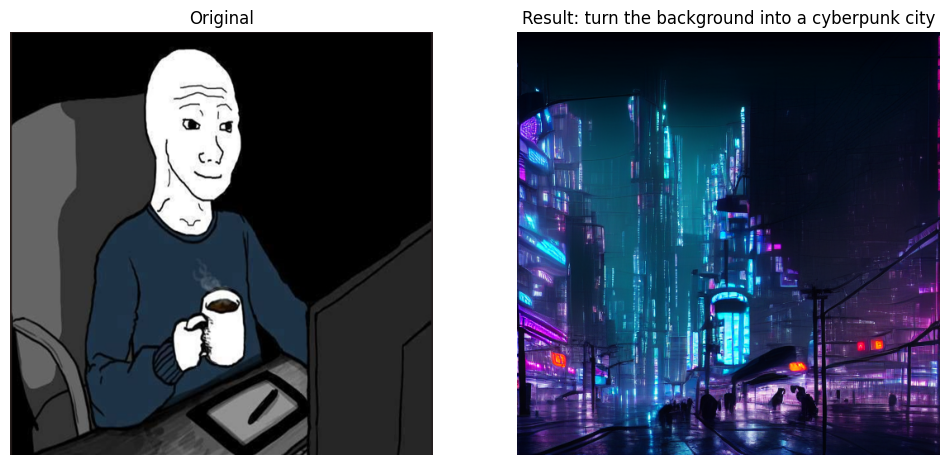

----------------------------------------
🎨 Generating 6/7: 'Make me study under the moon'...


  0%|          | 0/40 [00:00<?, ?it/s]

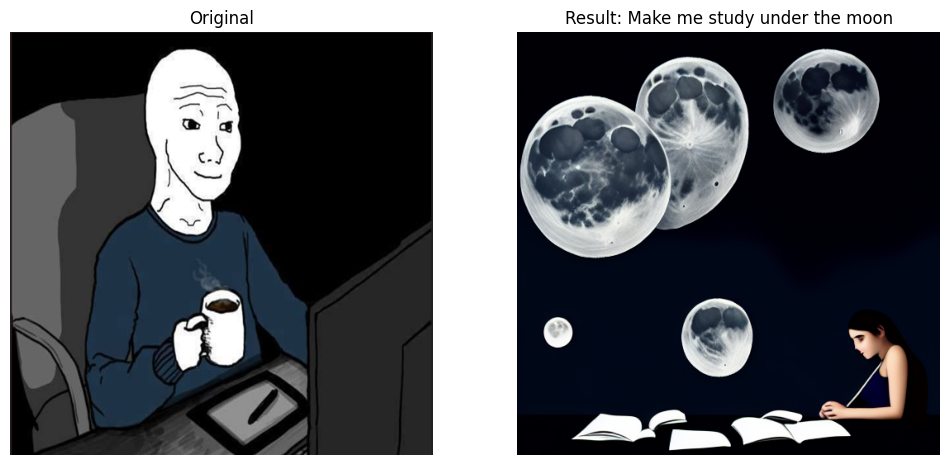

----------------------------------------
🎨 Generating 7/7: 'Make me hospitalized in hospital bed'...


  0%|          | 0/40 [00:00<?, ?it/s]

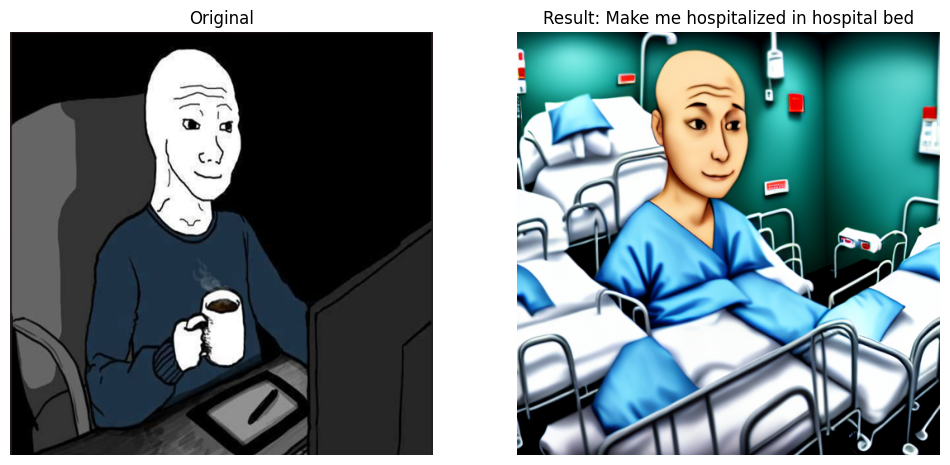

----------------------------------------
All done!


In [4]:
!pip install -q diffusers transformers accelerate

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
import matplotlib.pyplot as plt
import os
from google.colab import files

# 2. Setup & Image Upload
INPUT_IMAGE = "imagee.png"

# Check if image exists, if not, upload it
if not os.path.exists(INPUT_IMAGE):
    print(f"⚠️ '{INPUT_IMAGE}' not found. Please upload an image now.")
    uploaded = files.upload()
    # Rename the first uploaded file to input.jpg for simplicity
    if uploaded:
        first_file = list(uploaded.keys())[0]
        os.rename(first_file, INPUT_IMAGE)
        print(f"✅ Image saved as '{INPUT_IMAGE}'")
    else:
        raise FileNotFoundError("No image uploaded! Please re-run and upload an image.")

# 3. User Settings (NEW PROMPTS HERE)
PROMPT_LIST = [
    "Change the background to a snowy forest",
    "Make the lighting neon cyberpunk",
    "make me sit in open mountains",
    "make me sit in a modern classroom",
    "turn the background into a cyberpunk city",
    "Make me study under the moon",
    "Make me hospitalized in hospital bed",
]

IMAGE_STABILITY = 1.5  # Lowered slightly for better editability
TEXT_STRENGTH = 10.0   # Higher strength to force the prompt changes

# 4. Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Multi-Prompt Generator (Running on {device}) ---")

# Load Pipeline
model_id = "timbrooks/instruct-pix2pix"
dtype = torch.float16 if device == "cuda" else torch.float32
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id, torch_dtype=dtype, safety_checker=None
).to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# Process Input Image
original_image = Image.open(INPUT_IMAGE).convert("RGB")
original_image = original_image.resize((512, 512))

# 5. Generate & Display
print(f"Loaded image. Processing {len(PROMPT_LIST)} prompts...\n")

for i, prompt in enumerate(PROMPT_LIST):
    print(f"🎨 Generating {i+1}/{len(PROMPT_LIST)}: '{prompt}'...")

    with torch.no_grad():
        result = pipe(
            prompt,
            image=original_image,
            num_inference_steps=40,
            image_guidance_scale=IMAGE_STABILITY,
            guidance_scale=TEXT_STRENGTH
        ).images[0]

    # Display Inline
    plt.figure(figsize=(12, 6))

    # Left: Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis("off")

    # Right: Generated
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f"Result: {prompt}")
    plt.axis("off")

    plt.show()
    print("-" * 40)

print("All done!")